In [1]:
import nltk
#nltk.download()
import zipfile
import unidecode
import numpy as np
import pandas as pd
import seaborn as sns
from string import punctuation
import matplotlib.pyplot as plt
from nltk.corpus import stopwords
from nltk.tokenize import wordpunct_tokenize


In [2]:
wd = "C:/Users/jeann/Documents/prog_python/horror_predict/"

In [3]:
#Files were zipped, needed to unzip
names = ['test','train','sample_submission']
for name in names:
    with zipfile.ZipFile(wd + name + '.zip', 'r') as zip_ref:
        zip_ref.extractall(wd)

In [4]:
train = pd.read_csv(wd + "train.csv")
test = pd.read_csv(wd + "test.csv")
sample_submission = pd.read_csv(wd + "sample_submission.csv")

# Text Cleaning

In [5]:
def text_cleaning(text):
    """"
    Clean text of accent, punctuation, excess white spaces and remove stopwords 
    """
    stop_eng = set(stopwords.words('english'))

    text = unidecode.unidecode(text.lower().strip())
    text = " ".join(w for w in wordpunct_tokenize(text) if w not in punctuation)
    return " ".join(w for w in wordpunct_tokenize(text) if w not in stop_eng)

train['text_clean'] = train['text'].apply(lambda x: text_cleaning(x))
test['text_clean'] = test['text'].apply(lambda x: text_cleaning(x))

# Graphical Analysis of Text

In [6]:
#Construct a dictionnary containing the cleaned corpus for each author
#Then for each author we build a dictionnary containing the word frequency of the cleaned text.
byAuth = train.groupby('author')
authdict = {}
for name, group in byAuth:
    text = (" ".join(group['text_clean']))

    words = wordpunct_tokenize(text)
    #FreqDist => Create a dictionnary of the words with their frequencies in the text
    freq = nltk.FreqDist(words)
    #For each author we have a dictionnary of the word frequencies in the text 
    authdict[name]=(freq)
    

In [7]:
def auth_wordfreq_plot(word,print = True):
    """"
    Return a graph of the word frequency between the different author  
    """
    freqlist = []
    for i in authdict.keys():
        wordfreq = authdict[i].freq(word)
        freqlist.append(wordfreq)
        if print:
            print("blood: " + i)
            print(wordfreq)
            print("\n")
    return sns.barplot(x=list(authdict.keys()), y = freqlist)

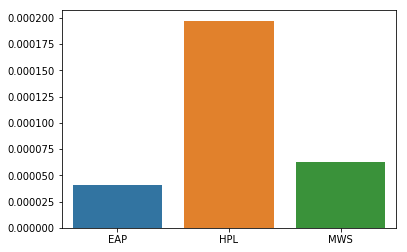

In [8]:
auth_wordfreq_plot("scream",print = False)


# First submission : probability calculation, No text cleaning

In [9]:
def auth_predict(text):
    final_score = {}
    tokens = wordpunct_tokenize(text)
    for i in authdict.keys():
        score = []
        for word in tokens:
            #smoothing, to avoid having any value at exactly 0 and ruining finale score
            score.append(authdict[i].freq(word)+0.000001)
        #Calculate the joint proba => product of each word proba
        final_score[i] = np.prod(score)

    return final_score

In [10]:
#Shape the data in a similar way to the sample submission
sub = test.copy()
for auth in authdict.keys():
    sub[auth]= sub['text'].apply(lambda x: auth_predict(x)[auth])
    

In [11]:
sub = test.drop(['text','text_clean'],axis = 1)
sub.set_index("id", inplace=True)
sub.head()

""
id
id02310
id24541
id00134
id27757
id04081


In [12]:
sub.to_csv("submission_v01.csv")

# Second Submission: Same as before but with text cleaning 
Score has improved slightly : 1.06580
But the improvement is so small, it's probably not interesting to continue in line of thought

In [13]:
sub = test.copy()
for auth in authdict.keys():
    sub[auth]= sub['text_clean'].apply(lambda x: auth_predict(x)[auth])
sub = test.drop(['text','text_clean'],axis = 1)
sub.set_index("id", inplace=True)
sub.to_csv("submission_v02.csv")

# Third submission: Logistic regression 
## Feature Building:
Construct a tfidf matrix of the cleaned text. see the difference between raw/clean text
Other improvement ideas: Stemming, semantic value of the words (author may use more adverbs? need some data explo)

In [15]:
from sklearn.linear_model import LogisticRegression